# American hand sign classification
[Michael Neuhold]

Dataset from Kaggle (asl -> american sign language classification)

Official description:
Sign language is one of the oldest and most natural forms of language for communication, but since most people do not know sign language and
interpreters are very difficult to come by => neural networks for ASL alphabet classification.

## Setup

### Dependencies

In [41]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread

from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import  LabelBinarizer
from tensorflow.keras.utils import img_to_array, array_to_img

from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU

### Mount GoogleDrive for data

In [2]:
## this is Colab-specific; remove if you are not using Colab
## connect drive as data source
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
## set data directory
base_dir = '/content/drive/MyDrive/'
data_dir = base_dir + 'datasets/asl_dataset'
model_location = base_dir + 'datasets/akt-models'

### Check if data is available

Data gets read from connected google drive

In [ ]:
# commented out for documentation (to long output)
#for dirname, _, filenames in os.walk(data_dir + ''):
#  for filename in filenames:
#    print(os.path.join(dirname, filename))

## Data analysis

### Printing all available target classes:

In [4]:
from os import listdir
total_signs=sorted(listdir(data_dir + "/asl_dataset"))
print(total_signs)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Plotting some images to get better understanding

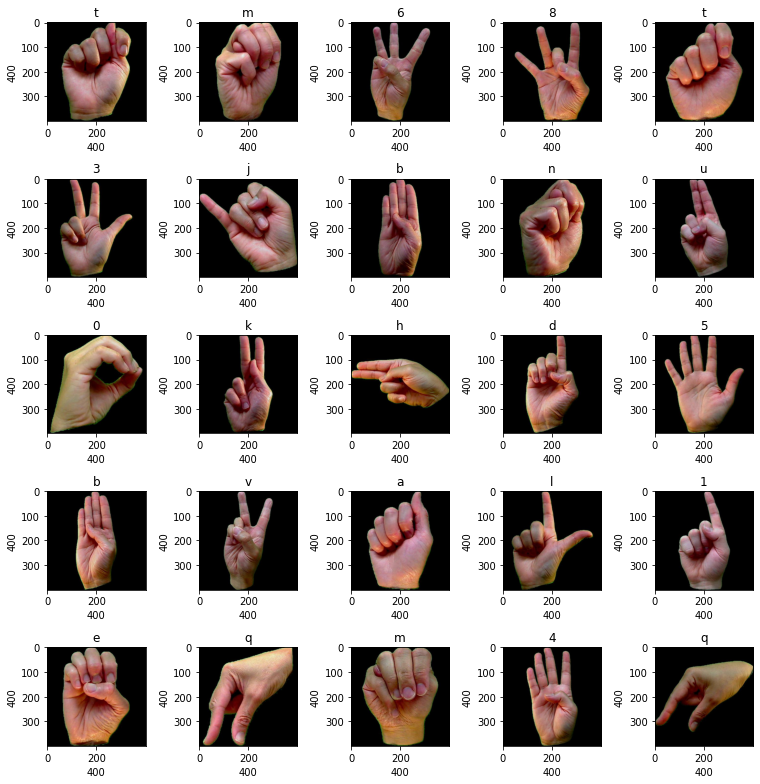

In [5]:
plt.figure(figsize=(11, 11))
path = data_dir
for i in range(1, 26):
  plt.subplot(5, 5, i)
  plt.tight_layout()
  directry=random.choice(total_signs)
  rand_img = imread(path + '/' + directry + '/' + random.choice(sorted(listdir(path+'/' + directry + '/'))))
  plt.imshow(rand_img)
  plt.title(directry)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)

### Check available data

In [ ]:
# commented out for documentation (to long output)
# for sign in total_signs:
#  print(pd.value_counts(data_dir + "/asl_dataset/" + sign))

In [6]:
dir1 = data_dir + "/asl_dataset/"
root_dir = listdir(dir1)
image_list, label_list = [], []
root_dir

['9',
 'u',
 'r',
 'i',
 't',
 '8',
 '0',
 '6',
 'z',
 '1',
 'g',
 '7',
 'n',
 's',
 'a',
 'v',
 'h',
 'c',
 'j',
 'd',
 'm',
 'f',
 'o',
 '3',
 'q',
 'k',
 'y',
 '4',
 'e',
 'l',
 'b',
 'x',
 '2',
 'p',
 'w',
 '5']

### Read image and do pre processing as well as converting images to numpy arrays

In [7]:
for directory in root_dir:
  for files in listdir(f"{dir1}/{directory}"):
    image_path = f"{dir1}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((50, 50))
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

In [8]:
label_counts = pd.DataFrame(label_list).value_counts()
number_of_classes = len(label_counts)
number_of_classes

36

### Data shape

In [9]:
np.array(image_list).shape

(2533, 50, 50, 3)

In [10]:
label_list = np.array(label_list)
label_list.shape

(2533,)

# Splitting dataset into test and train

In [11]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) # train / test split

# Normalize and reshape data

In [12]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 50, 50, 3)
x_test = x_test.reshape( -1, 50, 50, 3)

# Binarizing labels

In [13]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# Splitting the training data set into training and validation data set

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2) # train / validation split

In [15]:
print(y_train.shape)
print(x_train.shape)

(1620, 36)
(1620, 50, 50, 3)


## Building model

### 1. Variant

#### Model Definition

In [16]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), padding="same",input_shape=(50,50,3), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))
model_1.add(Conv2D(90, (3, 3), padding="same", activation="relu"))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(60, activation="relu"))
model_1.add(Flatten())

model_1.add(Dense(40, activation="relu"))
model_1.add(Dense(number_of_classes, activation="softmax")) # number of classes -> neurons in output layer
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 90)        26010     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 90)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5760)              0         
                                                                 
 dense (Dense)               (None, 60)                3

#### Model Training

In [17]:
model_1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(x_train, y_train, batch_size = 150, epochs = 50, validation_data = (x_val, y_val)) # incl. using validation data

Epoch 1/50
11/11 [==============================] - 7s 568ms/step - loss: 3.4008 - accuracy: 0.0728 - val_loss: 3.1101 - val_accuracy: 0.0788
Epoch 2/50
11/11 [==============================] - 5s 395ms/step - loss: 2.6809 - accuracy: 0.2981 - val_loss: 2.3058 - val_accuracy: 0.3793
Epoch 3/50
11/11 [==============================] - 4s 377ms/step - loss: 1.8622 - accuracy: 0.5136 - val_loss: 1.5352 - val_accuracy: 0.5419
Epoch 4/50
11/11 [==============================] - 4s 378ms/step - loss: 1.2497 - accuracy: 0.6290 - val_loss: 1.0795 - val_accuracy: 0.6724
Epoch 5/50
11/11 [==============================] - 4s 379ms/step - loss: 0.8081 - accuracy: 0.7481 - val_loss: 0.7758 - val_accuracy: 0.7488
Epoch 6/50
11/11 [==============================] - 4s 377ms/step - loss: 0.5869 - accuracy: 0.8130 - val_loss: 0.6250 - val_accuracy: 0.7685
Epoch 7/50
11/11 [==============================] - 4s 379ms/step - loss: 0.4269 - accuracy: 0.8580 - val_loss: 0.5273 - val_accuracy: 0.8300
Epoch 

## 2. Variant

### Model definition

In [19]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), padding="same",input_shape=(50,50,3), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Conv2D(90, (3, 3), padding="same", activation="relu"))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(90, (3, 3), padding="same", activation="relu"))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dense(60, activation="relu"))
model_2.add(Flatten())
model_2.add(Dense(40, activation="relu"))
model_2.add(Dense(number_of_classes, activation="softmax")) # number of classes -> neurons in output layer
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 90)        26010     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 90)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 90)          72990     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 90)        

### Model training

In [20]:
model_2.compile(optimizer='adamax', loss = 'categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(x_train, y_train, batch_size = 150, epochs = 20, validation_data = (x_val, y_val)) # incl. using validation data

Epoch 1/20
11/11 [==============================] - 6s 503ms/step - loss: 3.5412 - accuracy: 0.0914 - val_loss: 3.4775 - val_accuracy: 0.0985
Epoch 2/20
11/11 [==============================] - 5s 479ms/step - loss: 3.3798 - accuracy: 0.1025 - val_loss: 3.2526 - val_accuracy: 0.1404
Epoch 3/20
11/11 [==============================] - 5s 480ms/step - loss: 3.1211 - accuracy: 0.1358 - val_loss: 2.9272 - val_accuracy: 0.1970
Epoch 4/20
11/11 [==============================] - 5s 479ms/step - loss: 2.7942 - accuracy: 0.2086 - val_loss: 2.6271 - val_accuracy: 0.3227
Epoch 5/20
11/11 [==============================] - 5s 485ms/step - loss: 2.4116 - accuracy: 0.3123 - val_loss: 2.2922 - val_accuracy: 0.3842
Epoch 6/20
11/11 [==============================] - 6s 597ms/step - loss: 2.0486 - accuracy: 0.4315 - val_loss: 1.9426 - val_accuracy: 0.4187
Epoch 7/20
11/11 [==============================] - 6s 526ms/step - loss: 1.6946 - accuracy: 0.5222 - val_loss: 1.6292 - val_accuracy: 0.5222
Epoch 

## 3. Variant

### Model definition

In [54]:
model_3 = Sequential()
model_3.add(Conv2D(32, (3, 3), padding="same",input_shape=(50,50,3), activation="relu"))
model_3.add(MaxPooling2D(pool_size=(3, 3)))
model_3.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dense(60, activation="relu"))
model_3.add(Flatten())
model_3.add(Dense(40, activation="relu"))
model_3.add(Dense(number_of_classes, activation="softmax")) # number of classes -> neurons in output layer
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 4, 64)        

### Model training

In [55]:
model_3.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(x_train, y_train, batch_size = 150, epochs = 20, validation_data = (x_val, y_val)) # incl. using validation data

Epoch 1/20
11/11 [==============================] - 5s 407ms/step - loss: 3.5558 - accuracy: 0.0432 - val_loss: 3.4560 - val_accuracy: 0.0887
Epoch 2/20
11/11 [==============================] - 4s 390ms/step - loss: 3.2707 - accuracy: 0.1364 - val_loss: 2.8763 - val_accuracy: 0.2463
Epoch 3/20
11/11 [==============================] - 4s 385ms/step - loss: 2.5542 - accuracy: 0.2722 - val_loss: 2.0333 - val_accuracy: 0.3621
Epoch 4/20
11/11 [==============================] - 4s 389ms/step - loss: 1.6243 - accuracy: 0.4852 - val_loss: 1.4219 - val_accuracy: 0.5296
Epoch 5/20
11/11 [==============================] - 4s 389ms/step - loss: 1.1864 - accuracy: 0.6383 - val_loss: 1.1029 - val_accuracy: 0.6281
Epoch 6/20
11/11 [==============================] - 4s 390ms/step - loss: 0.8393 - accuracy: 0.7235 - val_loss: 0.9354 - val_accuracy: 0.6946
Epoch 7/20
11/11 [==============================] - 6s 595ms/step - loss: 0.6979 - accuracy: 0.7611 - val_loss: 0.7856 - val_accuracy: 0.7315
Epoch 

## 4. Variant

### Model definition

In [68]:
# Deeper network with more layers but results are not that good like those from the first variant
# It was also tried to replace the activation function (eg. with softmax) but with relu the best results are achieved on that dataset
model_4 = Sequential()
model_4.add(Conv2D(32, (3, 3), padding="same",input_shape=(50,50,3), activation="relu"))
model_4.add(MaxPooling2D(pool_size=(3, 3)))
model_4.add(Conv2D(90, (3, 3), padding="same", activation="relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Conv2D(90, (3, 3), padding="same", activation="relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Flatten())
model_4.add(Dense(40, activation="relu"))
model_4.add(Dense(number_of_classes, activation="softmax")) # number of classes -> neurons in output layer
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 90)        26010     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 8, 8, 90)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 128)         103808    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 4, 4, 128)       

### Model training

In [69]:
model_4.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()]) # defined: AUC evaluation metric
history_4 = model_4.fit(x_train, y_train, batch_size = 150, epochs = 25, validation_data = (x_val, y_val)) # incl. using validation data

Epoch 1/25
11/11 [==============================] - 9s 662ms/step - loss: 3.5603 - accuracy: 0.0580 - auc_2: 0.5582 - val_loss: 3.4691 - val_accuracy: 0.0764 - val_auc_2: 0.6788
Epoch 2/25
11/11 [==============================] - 7s 631ms/step - loss: 3.2414 - accuracy: 0.1265 - auc_2: 0.7406 - val_loss: 2.9528 - val_accuracy: 0.1798 - val_auc_2: 0.8112
Epoch 3/25
11/11 [==============================] - 7s 631ms/step - loss: 2.5350 - accuracy: 0.2809 - auc_2: 0.8769 - val_loss: 2.1619 - val_accuracy: 0.3547 - val_auc_2: 0.9080
Epoch 4/25
11/11 [==============================] - 7s 629ms/step - loss: 1.6237 - accuracy: 0.5093 - auc_2: 0.9544 - val_loss: 1.2759 - val_accuracy: 0.5665 - val_auc_2: 0.9677
Epoch 5/25
11/11 [==============================] - 7s 631ms/step - loss: 0.9245 - accuracy: 0.7000 - auc_2: 0.9837 - val_loss: 0.8921 - val_accuracy: 0.7143 - val_auc_2: 0.9802
Epoch 6/25
11/11 [==============================] - 9s 824ms/step - loss: 0.6759 - accuracy: 0.7809 - auc_2: 0

# Trainings history

Some helper functions for easy printing trainings history...

In [25]:
def printAccuracyHistoryOf(history):
  plt.figure(figsize=(12, 5))
  plt.plot(history.history['accuracy'], color='r')
  plt.plot(history.history['val_accuracy'], color='b')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'val'])
  plt.show()

In [26]:
def printLossHistoryOf(history):
  plt.figure(figsize=(12, 5))
  plt.plot(history.history['loss'], color='r')
  plt.plot(history.history['val_loss'], color='b')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'val'])
  plt.show()

## 1. Variant

### Accuracy history

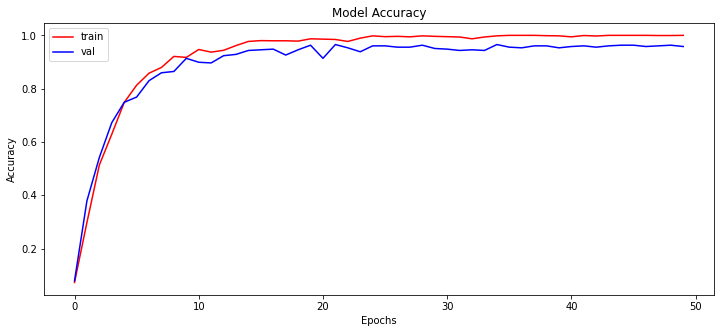

In [56]:
printAccuracyHistoryOf(history_1)

### Loss history

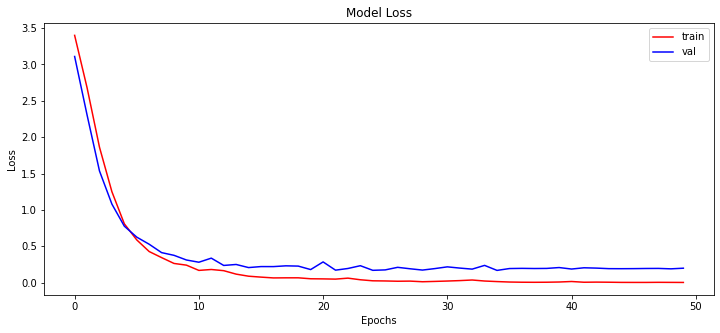

In [57]:
printLossHistoryOf(history_1)

## 2. Variant

### Accuracy history

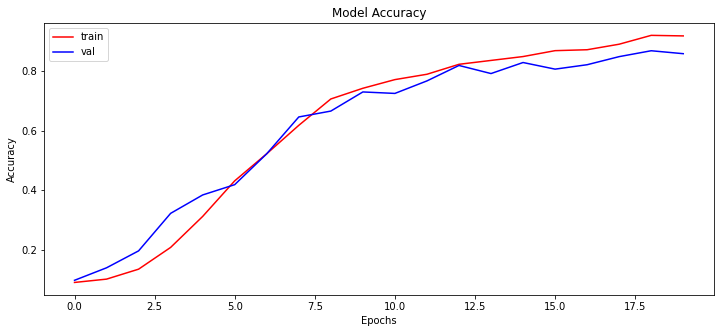

In [58]:
printAccuracyHistoryOf(history_2)

### Loss history

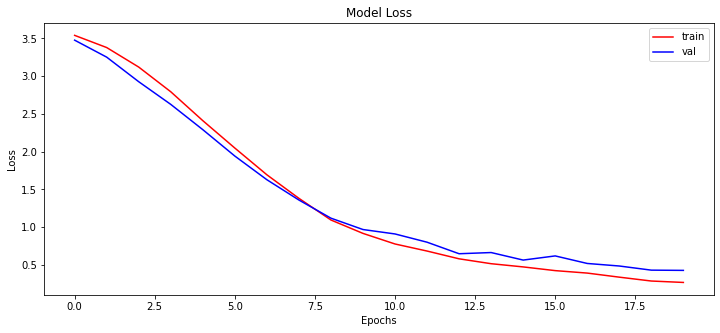

In [59]:
printLossHistoryOf(history_2)

## 3. Variant

### Accuracy history

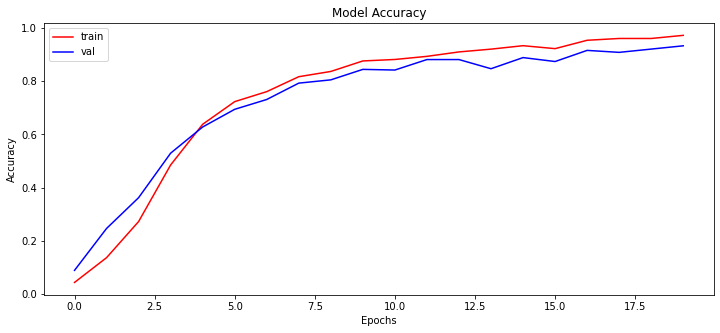

In [60]:
printAccuracyHistoryOf(history_3)

### Loss history

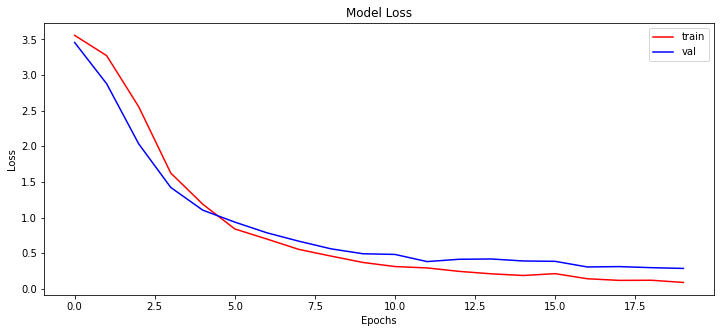

In [61]:
printLossHistoryOf(history_3)

## 4. Variant

### Accuracy history

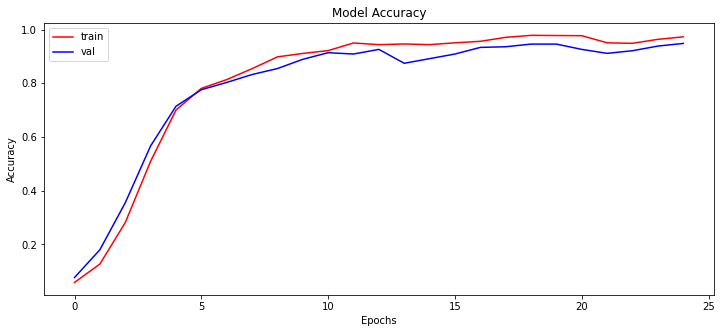

In [70]:
printAccuracyHistoryOf(history_4)

### Loss history

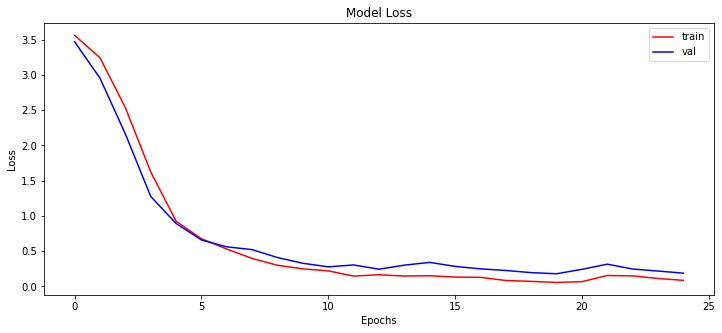

In [71]:
printLossHistoryOf(history_4)

# Save models

In [72]:
model_1.save(model_location + '/model-1.h5', save_format='h5')
model_2.save(model_location + '/model-2.h5', save_format='h5')
model_3.save(model_location + '/model-3.h5', save_format='h5')
model_4.save(model_location + '/model-4.h5', save_format='h5')

# Load models and evaluate on test data 

In [73]:
loaded_model_1 = keras.models.load_model(model_location + '/model-1.h5')
loaded_model_2 = keras.models.load_model(model_location + '/model-2.h5')
loaded_model_3 = keras.models.load_model(model_location + '/model-3.h5')
loaded_model_4 = keras.models.load_model(model_location + '/model-4.h5')

In [74]:
score_for_model_1 = loaded_model_1.evaluate(x_test, y_test)
score_for_model_2 = loaded_model_2.evaluate(x_test, y_test)
score_for_model_3 = loaded_model_3.evaluate(x_test, y_test)
score_for_model_4 = loaded_model_4.evaluate(x_test, y_test)

16/16 [==============================] - 1s 38ms/step - loss: 0.2538 - accuracy: 0.9349 - auc_2: 0.9945


## Final Results:

In [67]:
print(f"Model 1 | Test Accuracy: {score_for_model_1[1] * 100}%")
print(f"Model 2 | Test Accuracy: {score_for_model_2[1] * 100}%")
print(f"Model 3 | Test Accuracy: {score_for_model_3[1] * 100}%")
print(f"Model 4 | Test Accuracy: {score_for_model_4[1] * 100}%")

Model 1 | Test Accuracy: 96.05522751808167%
Model 2 | Test Accuracy: 86.39053106307983%
Model 3 | Test Accuracy: 91.32149815559387%
Model 4 | Test Accuracy: 11.834319680929184%


The best performing model is "Model 1 (Variant 1" which achieved 96% accuracy on the test dataset.

## Findings

- ASL dataset is nice to work with
- Image preprocessing and transforming it into the right shape was more elaborate than creating the train/test split and the model.
- Performing different models and trying out different activation functions as well as Pooling and Layer configurations
- Relu Activation performed best
- A bigger network does not meant that it has to perform better
- Saving and loading models is simple
